 # Healthcare reimbursement system. 

# 1. Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
#import scikitplot as skplt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

#### I. Load the dataset

In [2]:
# Load the dataset
data = pd.read_csv('healthcare_claims.csv')
# Create the DataFrame
df = pd.DataFrame(data)
# Display the first few rows of the dataset
print(df.head())


   claim_id diagnosis_code treatment_code  patient_age  patient_gender  \
0         1            A01            T01           45               1   
1         2            B02            T02           62               0   
2         3            A01            T01           33               1   
3         4            C03            T03           29               0   
4         5            D04            T04           50               0   

   claim_amount  accepted  
0        300.50         1  
1        500.00         0  
2        220.75         1  
3        150.00         0  
4        800.00         1  


#### II. Statistics

In [3]:
# Summary statistics of the dataset
print(df.describe())

       claim_id  patient_age  patient_gender  claim_amount   accepted
count  10.00000    10.000000       10.000000     10.000000  10.000000
mean    5.50000    43.500000        0.600000    430.175000   0.600000
std     3.02765    13.583078        0.516398    225.197631   0.516398
min     1.00000    23.000000        0.000000    150.000000   0.000000
25%     3.25000    33.500000        0.000000    240.687500   0.000000
50%     5.50000    43.000000        1.000000    425.000000   1.000000
75%     7.75000    55.250000        1.000000    575.125000   1.000000
max    10.00000    62.000000        1.000000    800.000000   1.000000


#### III. Data type and Conversions

In [4]:
# Convert to diagonis_code and treatment_code to string - for memory efficiency and faster operations
#df['diagnosis_code'] = df['diagnosis_code'].astype("string")
#df['treatment_code'] = df['treatment_code'].astype("string")

# Check data types and missing values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   claim_id        10 non-null     int64  
 1   diagnosis_code  10 non-null     object 
 2   treatment_code  10 non-null     object 
 3   patient_age     10 non-null     int64  
 4   patient_gender  10 non-null     int64  
 5   claim_amount    10 non-null     float64
 6   accepted        10 non-null     int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 692.0+ bytes
None


#### IV. Distribution of Features

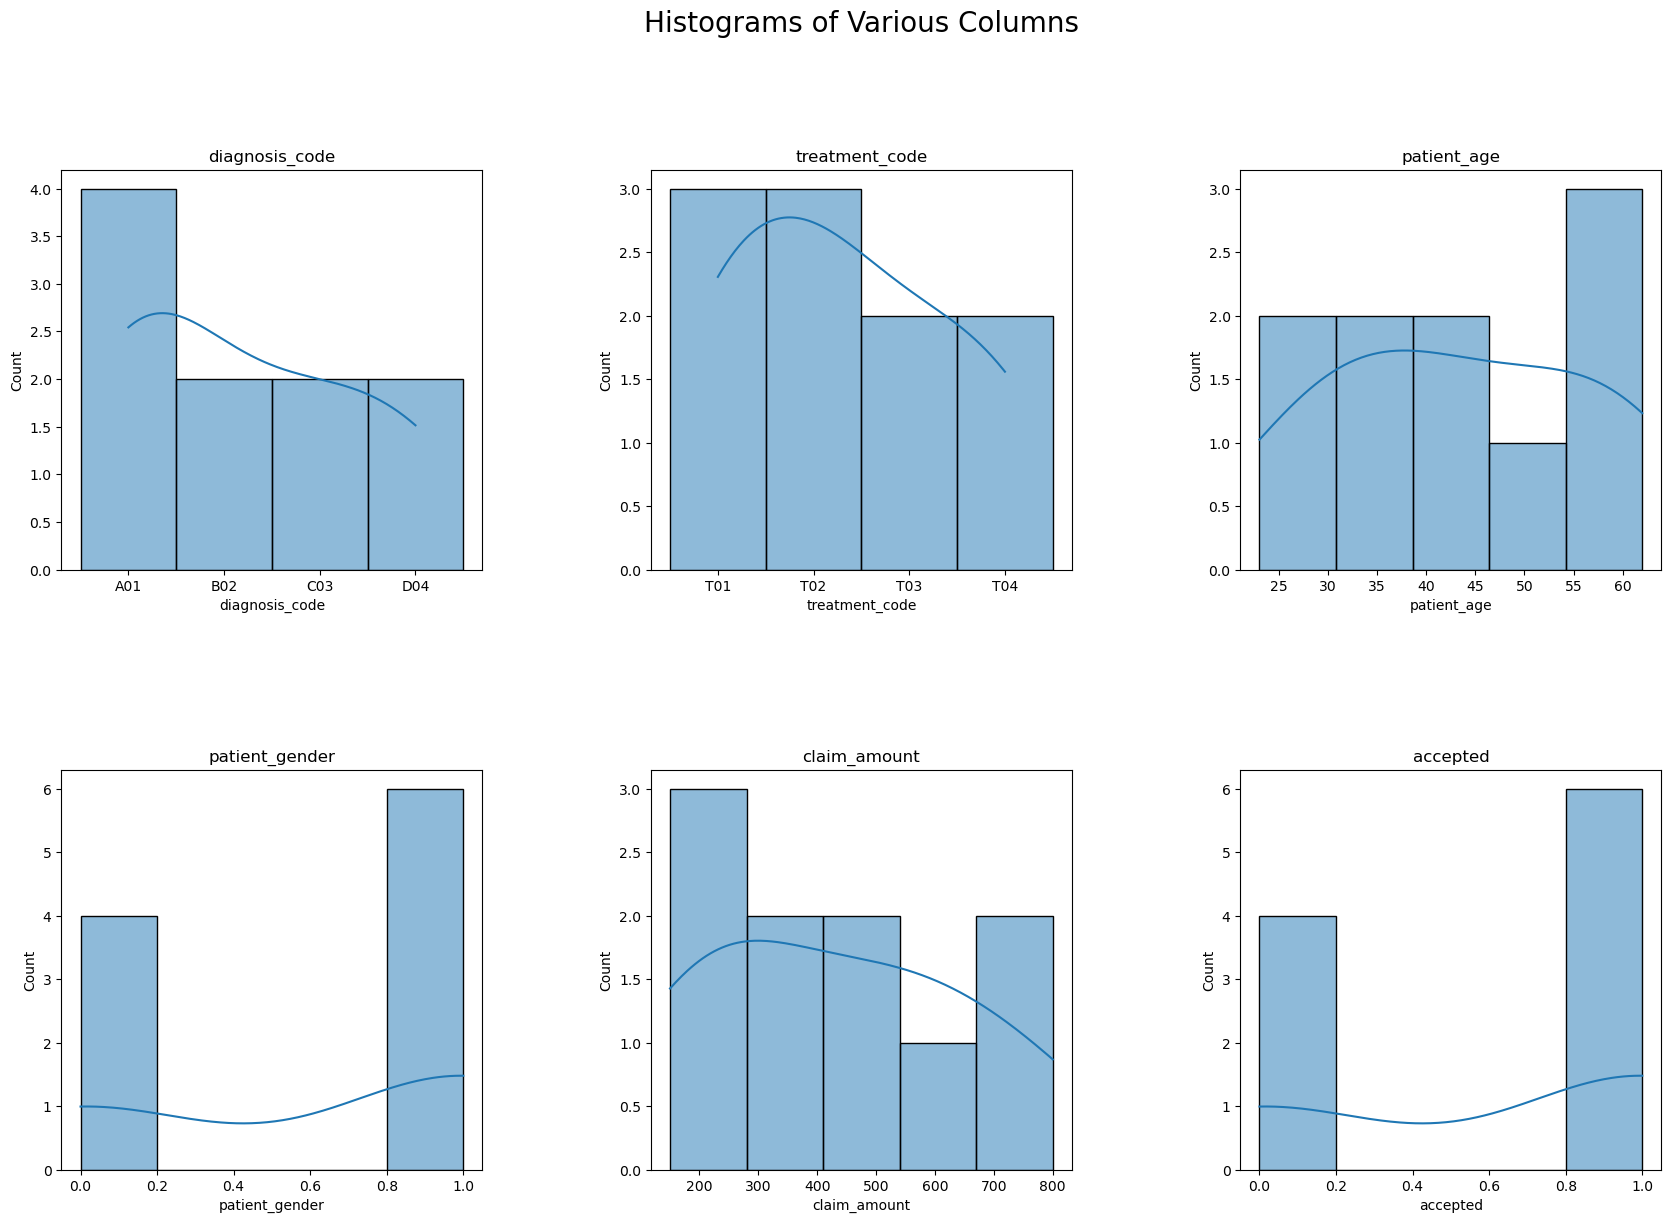

In [5]:
# Set the figure size
plt.figure(figsize=(20, 20))

# List of columns to plot, excluding 'claim_id'
columns_to_plot = [
    "diagnosis_code",
    "treatment_code",
    "patient_age",
    "patient_gender",
    "claim_amount",
    "accepted"
]
# Loop through the columns and create a subplot for each
for i, column in enumerate(columns_to_plot, 1):
    # Create a subplot with 3 rows and 3 columns
    plt.subplot(3, 3, i)
    # Plot a histogram with KDE for the current column
    sns.histplot(data=df[column], kde=True)
    # Set the title of the subplot to the column name
    plt.title(column)
    # Set the x-axis label to the column name
    plt.xlabel(column)

# Adjust the padding between subplots
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.5, wspace=0.4)

# Add a main title to the entire figure
plt.suptitle('Histograms of Various Columns', fontsize=20)

# Display the plots
plt.show()

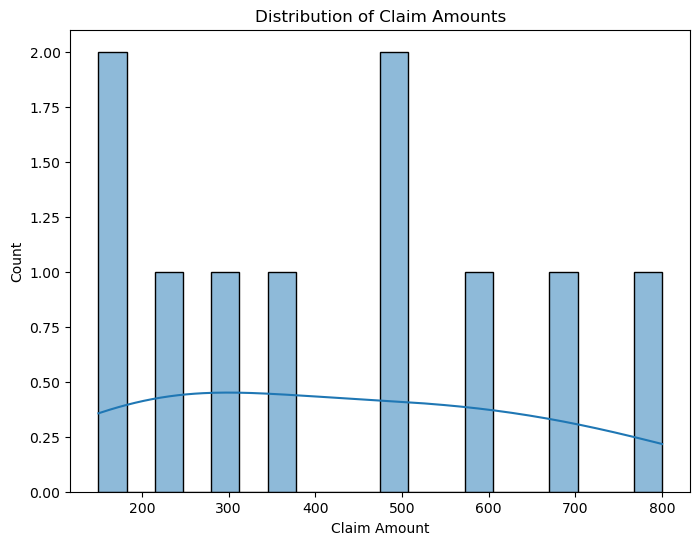

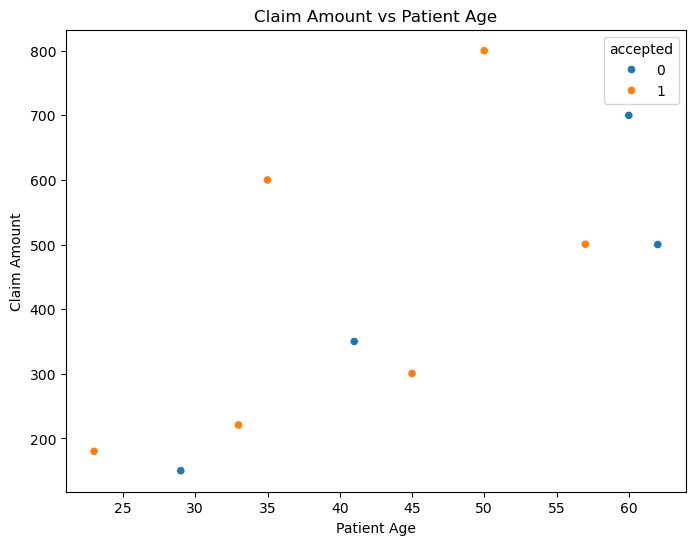

In [6]:
# Visualize the distribution of claim amounts
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x="claim_amount", bins=20, kde=True)
plt.title("Distribution of Claim Amounts")
plt.xlabel("Claim Amount")
plt.ylabel("Count")
plt.show()

# Visualize the relationship between claim amount and patient age
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="patient_age", y="claim_amount", hue="accepted")
plt.title("Claim Amount vs Patient Age")
plt.xlabel("Patient Age")
plt.ylabel("Claim Amount")
plt.show()

#### V. Correlation for Numeric columns

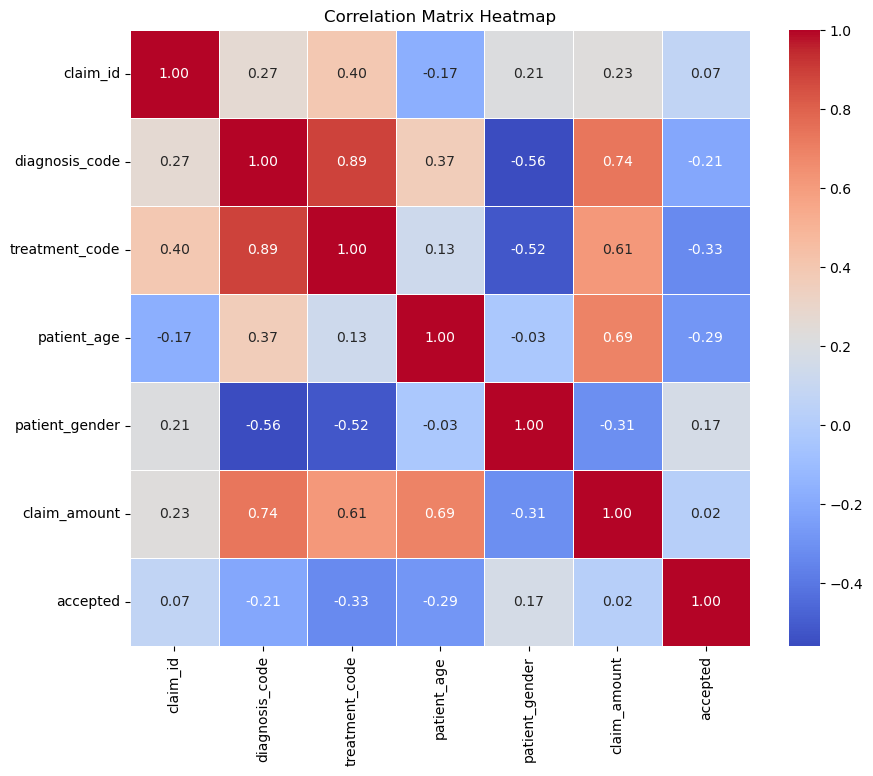

In [7]:
# Convert 'diagnosis_code' to numeric (assuming ordinal relationship)
diagnosis_mapping = {'A01': 1, 'B02': 2, 'C03': 3, 'D04': 4}
# Use .map(diagnosis_mapping) and fill any NaN with a specific placeholder, e.g., -1
df['diagnosis_code'] = df['diagnosis_code'].map(diagnosis_mapping).fillna(-1)

# Convert 'treatment_code' to numeric (assuming ordinal relationship)
treatment_mapping = {'T01': 1, 'T02': 2, 'T03': 3, 'T04': 4}
# Use .map(treatment_mapping) and fill any NaN with a specific placeholder, e.g., -1
df['treatment_code'] = df['treatment_code'].map(treatment_mapping).fillna(-1)

# Select only numeric columns for correlation computation
numeric_df = df.select_dtypes(include=[float, int])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# 2. Build a Model

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Generate synthetic dataset
# np.random.seed(42)
# n_samples = 1000
# data = pd.DataFrame({
#     'diagnosis_code': np.random.choice(['A01', 'B02', 'C03', 'D04'], n_samples),
#     'treatment_code': np.random.choice(['T01', 'T02', 'T03', 'T04'], n_samples),
#     'patient_age': np.random.randint(18, 90, n_samples),
#     'patient_gender': np.random.choice([0, 1], n_samples),
#     'claim_amount': np.random.uniform(100, 1000, n_samples),
#     'accepted': np.random.choice([0, 1], n_samples)
# })


# Encoding categorical variables
le_diag = LabelEncoder()
le_treat = LabelEncoder()
df['diagnosis_code'] = le_diag.fit_transform(df['diagnosis_code'])
df['treatment_code'] = le_treat.fit_transform(df['treatment_code'])

# Splitting features and target
X = df[['diagnosis_code', 'treatment_code', 'patient_age', 'patient_gender', 'claim_amount']]
y = df['accepted']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 3. Optimize model selection and performance

In [22]:
# Random Forest Model Training and Optimization
rf = RandomForestClassifier()
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
clf = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')
clf.fit(X_train, y_train)

# Best Random Forest Model Evaluation
y_pred_rf = clf.best_estimator_.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# Logistic Regression Model Training
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Logistic Regression Evaluation
y_pred_lr = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Logistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))

# Perform 5-fold cross-validation for Random Forest
cv_scores_rf = cross_val_score(clf.best_estimator_, X, y, cv=2, scoring='accuracy')
print("Random Forest Cross-Validation Scores:", cv_scores_rf)
print("Random Forest Mean Accuracy:", np.mean(cv_scores_rf))

# Perform 5-fold cross-validation for Logistic Regression
cv_scores_lr = cross_val_score(log_reg, X, y, cv=2, scoring='accuracy')
print("Logistic Regression Cross-Validation Scores:", cv_scores_lr)
print("Logistic Regression Mean Accuracy:", np.mean(cv_scores_lr))


/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Random Forest Accuracy: 0.0
Random Forest Confusion Matrix:
 [[0 1]
 [0 0]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0

Logistic Regression Accuracy: 0.0
Logistic Regression Confusion Matrix:
 [[0 1]
 [0 0]]
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       1.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_

Random Forest Cross-Validation Scores: [0.6 0.6]
Random Forest Mean Accuracy: 0.6
Logistic Regression Cross-Validation Scores: [0.8 0.6]
Logistic Regression Mean Accuracy: 0.7


# 4. Identifying Similar Groups of Claims

#### To identify similar groups of claims, we can use clustering techniques such as K-Means:

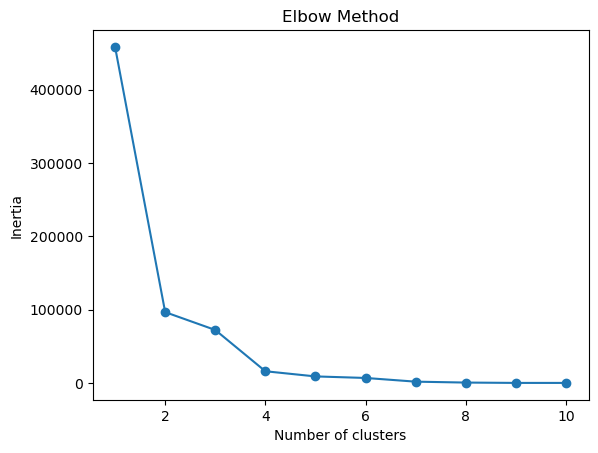

In [9]:
from sklearn.cluster import KMeans

# Encode categorical features
label_encoder = LabelEncoder()
data['diagnosis_code'] = label_encoder.fit_transform(data['diagnosis_code'])
data['treatment_code'] = label_encoder.fit_transform(data['treatment_code'])

# Select features for clustering
X = data[['diagnosis_code', 'treatment_code', 'patient_age', 'patient_gender', 'claim_amount']]

# Determine the optimal number of clusters using the elbow method
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()



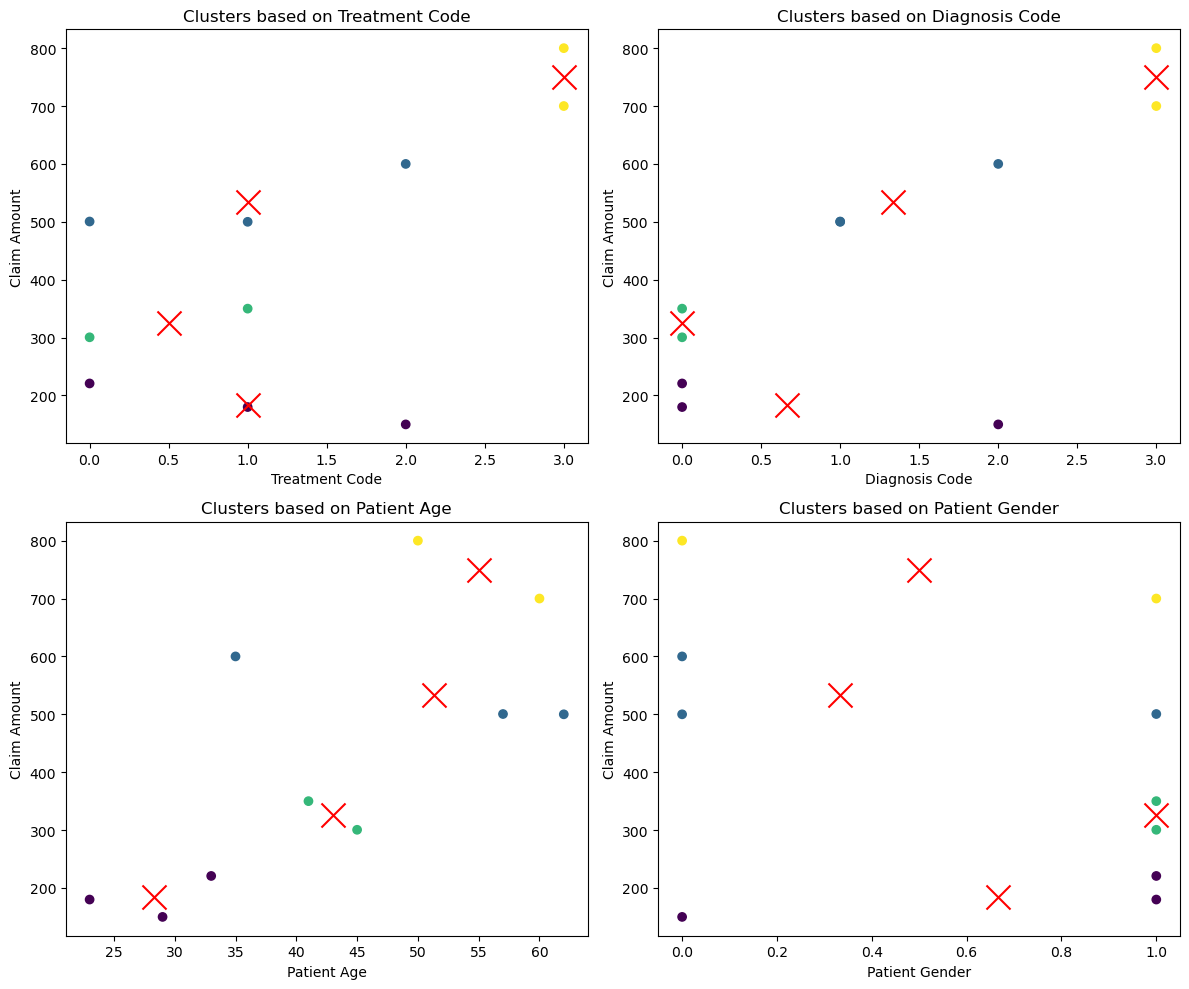

In [10]:
# Fit KMeans with the optimal number of clusters
optimal_clusters = 4    #elbow point is at 4 clusters as decrease is slower after
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(X)

# Assign cluster labels to the data
data['cluster'] = kmeans.labels_

# Visualize the clusters
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].scatter(data['treatment_code'], data['claim_amount'], c=data['cluster'], cmap='viridis')
axes[0, 0].scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 4], s=300, c='red', marker='x')
axes[0, 0].set_title('Clusters based on Treatment Code')
axes[0, 0].set_xlabel('Treatment Code')
axes[0, 0].set_ylabel('Claim Amount')

axes[0, 1].scatter(data['diagnosis_code'], data['claim_amount'], c=data['cluster'], cmap='viridis')
axes[0, 1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 4], s=300, c='red', marker='x')
axes[0, 1].set_title('Clusters based on Diagnosis Code')
axes[0, 1].set_xlabel('Diagnosis Code')
axes[0, 1].set_ylabel('Claim Amount')

axes[1, 0].scatter(data['patient_age'], data['claim_amount'], c=data['cluster'], cmap='viridis')
axes[1, 0].scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 4], s=300, c='red', marker='x')
axes[1, 0].set_title('Clusters based on Patient Age')
axes[1, 0].set_xlabel('Patient Age')
axes[1, 0].set_ylabel('Claim Amount')

axes[1, 1].scatter(data['patient_gender'], data['claim_amount'], c=data['cluster'], cmap='viridis')
axes[1, 1].scatter(kmeans.cluster_centers_[:, 3], kmeans.cluster_centers_[:, 4], s=300, c='red', marker='x')
axes[1, 1].set_title('Clusters based on Patient Gender')
axes[1, 1].set_xlabel('Patient Gender')
axes[1, 1].set_ylabel('Claim Amount')

plt.tight_layout()
plt.show()

# 5. Future Work and Deployment

### Model Deployment Steps:



1. Model Packaging: Save the trained model using a serialization technique like joblib or pickle.
2. API Development: Develop a RESTful API using frameworks like Flask or Django to serve the model predictions.
3. Containerization: Use Docker to containerize the API and model to ensure consistency across different environments.
4. Continuous Integration/Continuous Deployment (CI/CD): Set up CI/CD pipelines to automate testing and deployment using tools like Jenkins or GitHub Actions.
5. Monitoring: Implement monitoring using tools like Prometheus and Grafana to track model performance and ensure its reliability in production.

### Extend the Model Using Deep Learning


1. Data Preparation: Extend the data to be suitable for deep learning models. This includes normalizing numerical features and encoding categorical features as well.
2. Model Architecture: Design a neural network architecture, potentially using frameworks like TensorFlow or Keras. Consider using layers such as Dense, Dropout, and BatchNormalization.
3. Training and Evaluation: Train the neural network on the training dataset and evaluate its performance on the test dataset. Use metrics like accuracy, precision, recall, and F1 score.
4. Hyperparameter Tuning: Experiment with different architectures, learning rates, and batch sizes to optimize model performance.
5. Deployment: Follow similar steps for deployment as mentioned above, with additional considerations for handling the computational requirements of deep learning models.